<a href="https://colab.research.google.com/github/Elwing-Chou/ml0930/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from urllib.request import urlretrieve
url = "https://github.com/Elwing-Chou/ml0930/raw/master/titanic/train.csv"
urlretrieve(url, "train.csv")
url = "https://github.com/Elwing-Chou/ml0930/raw/master/titanic/test.csv"
urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x7f97a7208160>)

In [2]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
datas = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [4]:
datas = datas.drop(["PassengerId", "Survived"], axis=1)

In [5]:
na = datas.isna().sum()
# 篩選 Series[True/False list/series]
na[na > 0].sort_values(ascending=False)

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64

In [6]:
most = datas["Embarked"].value_counts().idxmax()
datas["Embarked"] = datas["Embarked"].fillna(most)

In [7]:
# 先處理一下ticket
dic = datas["Ticket"].value_counts()
def count(n):
    return dic[n]
datas["Ticket"] = datas["Ticket"].apply(count)

In [8]:
med = datas.median().drop(["Pclass"])
datas = datas.fillna(med)

In [9]:
# 一個段落, 看一下還缺啥
na = datas.isna().sum()
# 篩選 Series[True/False list/series]
na[na > 0].sort_values(ascending=False)

Cabin    1014
dtype: int64

In [10]:
def cabin(c):
    if pd.isna(c):
        return None
    else:
        return c[0]
datas["Cabin"] = datas["Cabin"].apply(cabin)

In [11]:
def name(n):
    mid = n.split(",")[-1].split(".")[0]
    mid = mid.strip()
    return mid
middle = datas["Name"].apply(name)
counts = middle.value_counts()
reserved = counts[:4].index
def name2(mid):
    if mid in reserved:
        return mid
    else:
        return None
datas["Name"] = middle.apply(name2)

In [12]:
datas = pd.get_dummies(datas)
datas = pd.get_dummies(datas, columns=["Pclass"])

In [13]:
datas["Family"] = datas["SibSp"] + datas["Parch"]
datas

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [14]:
# [first row, second row....]
x_train = datas.iloc[:len(train_df)]
x_predict = datas.iloc[len(train_df):]
y_train = train_df["Survived"]
x_predict

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
891,34.5,0,0,1,7.8292,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
892,47.0,1,0,1,7.0000,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
893,62.0,0,0,1,9.6875,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
894,27.0,0,0,1,8.6625,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
895,22.0,1,1,2,12.2875,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators":range(20, 21),
    "max_depth":range(4, 5)
}
clf = RandomForestClassifier(random_state=1)
cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
print(cv.best_score_)
print(cv.best_params_)

0.8271660424469414
{'max_depth': 4, 'n_estimators': 20}


In [21]:
import numpy as np
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(n_estimators=63, max_depth=7)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print(scores)
print(np.average(scores))

[0.81111111 0.88764045 0.73033708 0.88764045 0.85393258 0.83146067
 0.85393258 0.79775281 0.87640449 0.83146067]
0.836167290886392


In [22]:
clf = RandomForestClassifier(n_estimators=63, max_depth=7)
clf.fit(x_train, y_train)
pre = clf.predict(x_predict)
df = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
df.to_csv("rf.csv", encoding="utf-8", index=False)

In [28]:
clf.estimators_[0]
pd.DataFrame({
    "columns":x_train.columns,
    "importance":clf.feature_importances_
}).sort_values("importance", axis=0, ascending=False)

,columns,importance
7,Name_Mr,0.178528
10,Sex_male,0.130485
9,Sex_female,0.130231
4,Fare,0.099529
0,Age,0.078059
24,Pclass_3,0.060536
25,Family,0.056389
3,Ticket,0.053362
22,Pclass_1,0.036365
1,SibSp,0.026782


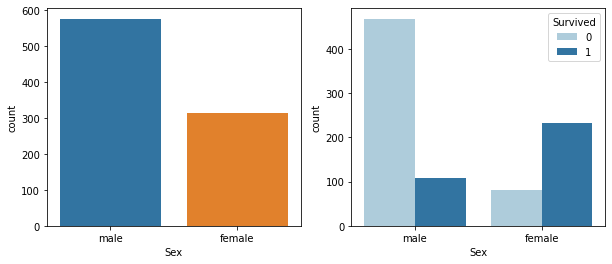

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=train_df["Sex"])
plt.subplot(1, 2, 2)
sns.countplot(x=train_df["Sex"], hue=train_df["Survived"], palette="Paired")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

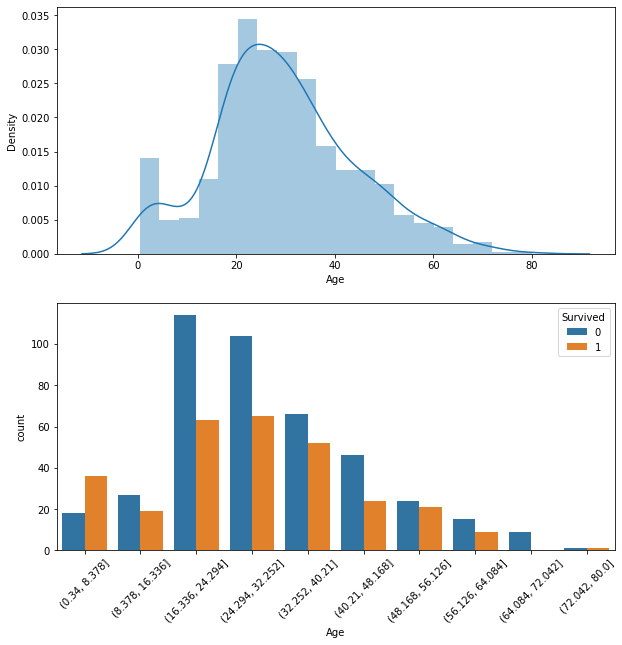

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.distplot(train_df["Age"])
c = pd.cut(train_df["Age"], bins=10)
plt.subplot(2, 1, 2)
sns.countplot(x=c, hue=train_df["Survived"])
plt.xticks(rotation=45)

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datas_scale = scaler.fit_transform(datas)
datas_scale = pd.DataFrame(datas_scale, columns=datas.columns)
x_train_scale = datas_scale.iloc[:len(train_df)]
x_predict_scale = datas_scale.iloc[len(train_df):]
x_predict_scale

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
891,0.430039,0.000,0.000000,0.0,0.015282,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
892,0.586622,0.125,0.000000,0.0,0.013663,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.1
893,0.774521,0.000,0.000000,0.0,0.018909,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
894,0.336089,0.000,0.000000,0.0,0.016908,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
895,0.273456,0.125,0.111111,0.1,0.023984,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.348616,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1305,0.486409,0.000,0.000000,0.2,0.212559,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1306,0.480145,0.000,0.000000,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1307,0.348616,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [19]:
from sklearn.neighbors import KNeighborsClassifier
params = {
    "n_neighbors":range(5, 100),
}
clf = KNeighborsClassifier()
cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train_scale, y_train)
print(cv.best_score_)
print(cv.best_params_)

0.832796504369538
{'n_neighbors': 7}


In [20]:
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(x_train_scale, y_train)
pre = clf.predict(x_predict_scale)
df = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
df.to_csv("knn.csv", encoding="utf-8", index=False)